In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [2]:
## convert one to multiple series
def lag_ahead_series(data, name, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('{}{}(t-{})'.format(name, j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('{}{}(t+{})'.format(name, j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "rain"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()


## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}_{}".format(name,i), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))
    

In [3]:
train = pd.read_csv("../data/train_nocat.csv")
test = pd.read_csv("../data/test_nocat.csv")

In [64]:
train = train.set_index("Unnamed: 0")
test = test.set_index("Unnamed: 0")

### Seeking outliers

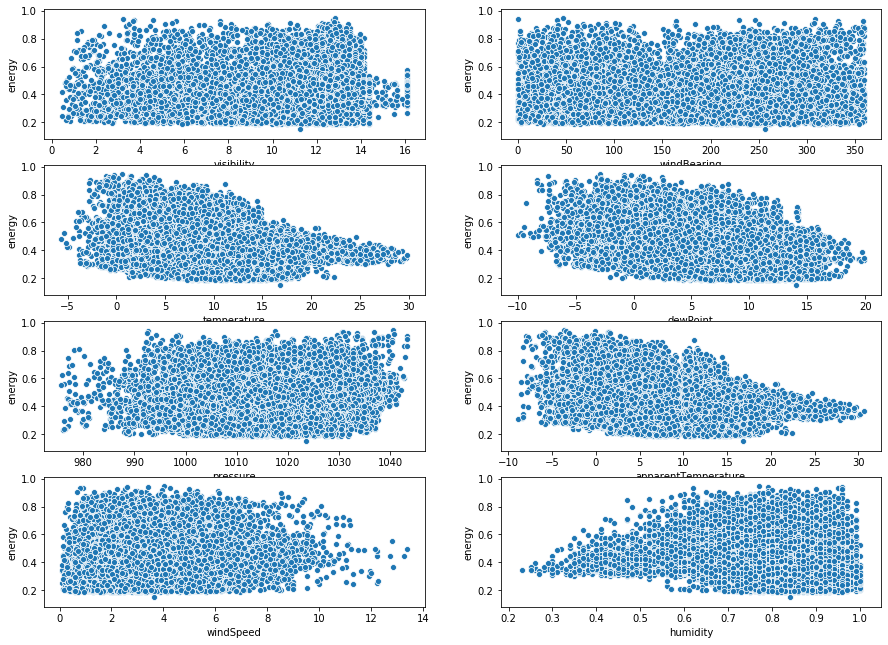

In [8]:
scatter_plot(train)

In [13]:
## deal with the only outliers in  energy data 
train.drop(train[(train["energy"] > 20)].index, inplace = True)
train.reset_index(drop=True, inplace=True)

### Calibration of distribution

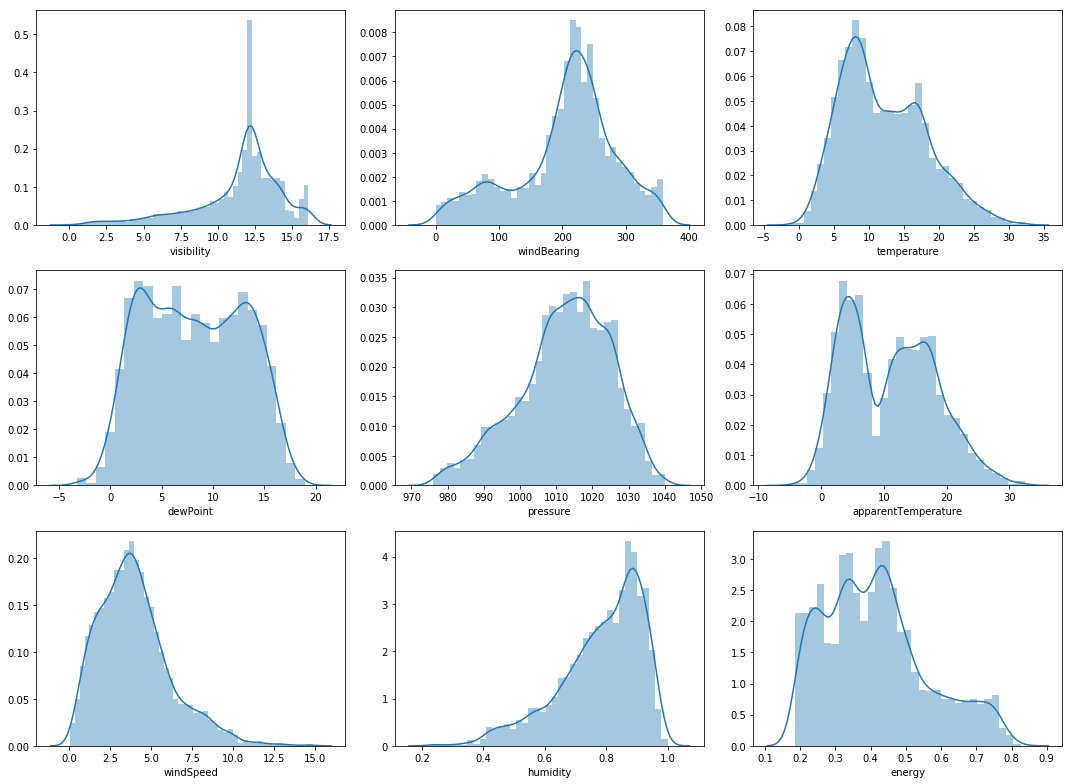

In [13]:
distri_plot(test)


We can observe that 
- left skew: **visibility**, **humidty** 
- right skew:  **windSpeed**, **temperature**
- weird shape: **windBearing**, **dewPoint**, **apparetTemp**

Apply transformation on them for more normal distribution

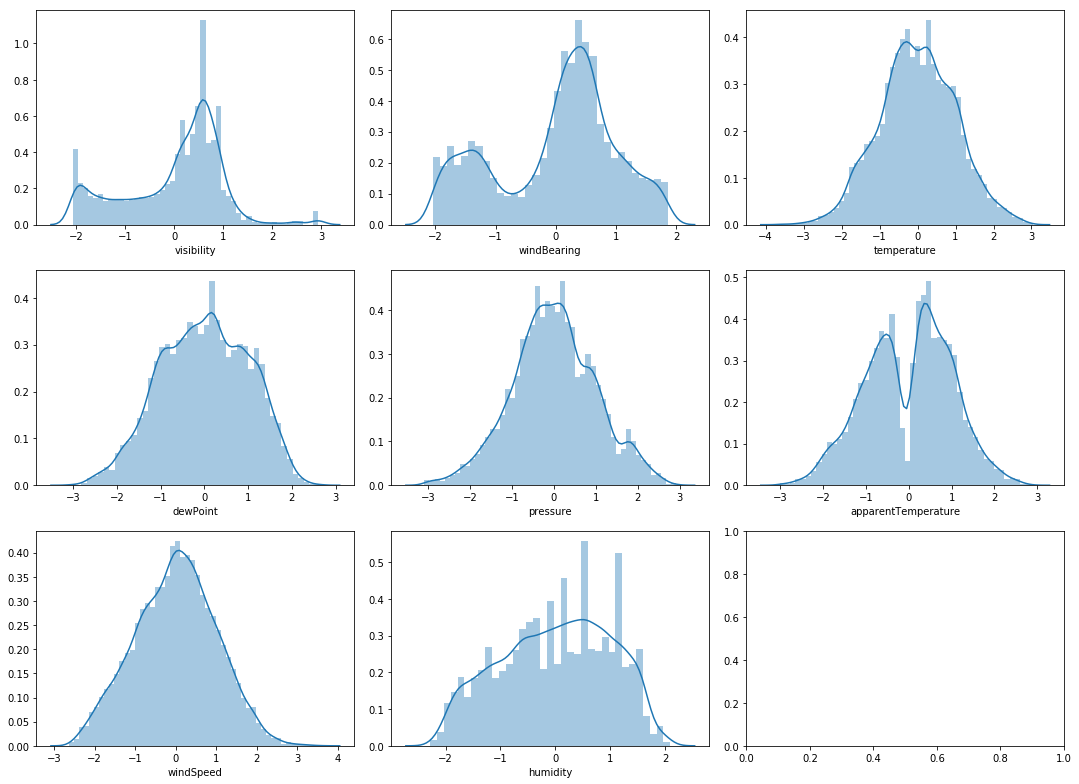

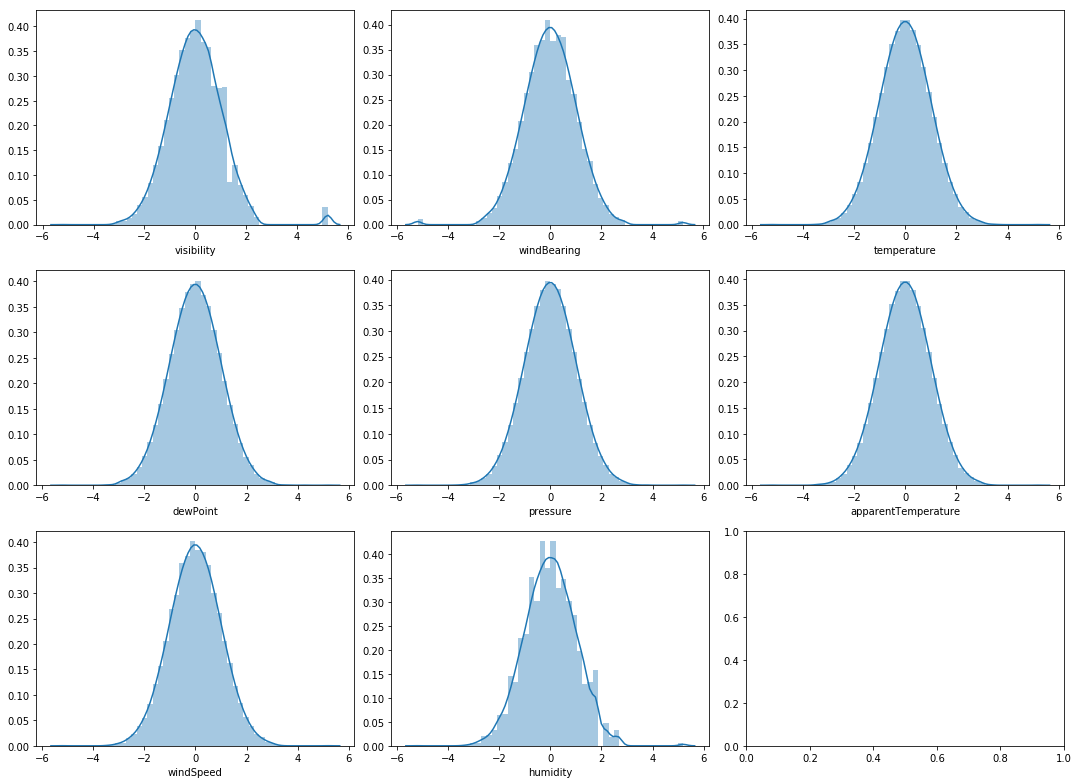

In [294]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
    
def power_trans(df):
    pt_boxc = PowerTransformer(method = "yeo-johnson")
    df_slice = df.iloc[:,:8]
    pt.fit(df_slice)
    df_trans = pd.DataFrame(pt.transform(df_slice), columns=['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'])
    return df_trans
train_trans = power_trans(train)

def quantile_trans(df):
    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
    df_slice = df.iloc[:,:8]
    qt.fit(df_slice)
    df_trans = pd.DataFrame(qt.transform(df_slice), columns=['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'])
    return df_trans

train_trans = power_trans(train)
train_quantile = quantile_trans(train)

##plot distribution
distri_plot(train_trans)
distri_plot(train_quantile)

### Creat lag ahead scenarios

In [65]:
#create 48 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,:8], "w", n_in=0, n_out=49, n_vars = 8, dropnan=True)
#single_w = train.iloc[:13991,:8]
#create 48 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,8:], "response", n_in=0, n_out=49, n_vars = 1, dropnan=True)
train_h2o = pd.concat([ahead_w,ahead_e], axis = 1)
ahead_w.shape, ahead_e.shape, train_h2o.shape


((13991, 392), (13991, 49), (13991, 441))

In [66]:
## create 48 hours recency effect matrix
ahead_wt = lag_ahead_series(test.iloc[:,:8], "w", n_in=0, n_out=49, n_vars = 8, dropnan=True)
#single_wt = train.iloc[:5775,:8]
#create 48 housrs ahead energy consumption matrix
ahead_et = lag_ahead_series(test.iloc[:,8:], "response", n_in=0, n_out=49, n_vars = 1, dropnan=True)
test_h2o = pd.concat([ahead_wt,ahead_et], axis = 1)
ahead_wt.shape, ahead_et.shape, test_h2o.shape

((5775, 392), (5775, 49), (5775, 441))

In [67]:
train_h2o.to_csv("../data/train_h2o.csv",index = False)
test_h2o.to_csv("../data/test_h2o.csv",index = False)

## h2o

In [11]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,4 mins 44 secs
H2O cluster timezone:,Europe/Stockholm
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.2
H2O cluster version age:,1 month and 27 days
H2O cluster name:,H2O_from_python_charles_9ge6z3
H2O cluster total nodes:,1
H2O cluster free memory:,3.546 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [51]:
from h2o.utils.shared_utils import _locate

## Import train
train = h2o.import_file(path = _locate("../data/train_h2o.csv"))

## Import test
test = h2o.import_file(path = _locate("../data/test_h2o.csv"))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
training , validation = train.split_frame(ratios = [.8], seed = 132)

In [98]:
y_pred = pd.DataFrame()
for res in training.columns[392:]:
    data_rfe = H2OAutoML(max_runtime_secs= 400, seed = 123)
    predictors = training.columns[0:392]
    data_rfe.train(x = predictors,
                   y = res,
                   training_frame = training,
                   validation_frame = validation)
    lb_reg = data_rfe.leader
    y_hat = lb_reg.predict(test[:5,:392]).as_data_frame()
    y_pred = pd.concat([y_pred, y_hat], axis = 1)
    

AutoML progress: |
01:25:55.902: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |
01:32:40.12: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |
01:39:23.593: User specified a validation frame with cross-validation still enabled. Please note that the mode

████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |
03:33:49.115: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |
03:40:32.800: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |███████████████████████████

05:34:58.801: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |
05:41:42.641: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |
05:48:26.264: User specified a validation frame with cross-validation still enabled. Please note that the models will still be v

In [99]:
data_rfe.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200319_064901,0.00184401,0.042942,0.00184401,0.0318055,0.0291308
XGBoost_1_AutoML_20200319_064901,0.00200632,0.0447919,0.00200632,0.033277,0.0301757
XGBoost_2_AutoML_20200319_064901,0.00243968,0.0493931,0.00243968,0.0367272,0.0332038


### Evaluation

In [143]:
test_y = np.transpose(test[:1,392:].as_data_frame().to_numpy())
pred_y = np.transpose(y_pred.iloc[:1,:].to_numpy())
get_eval(test_y, pred_y)

MSE: 0.0010537227203548112
MAE: 0.02587962854331835
r2_score: 0.8620814010697694


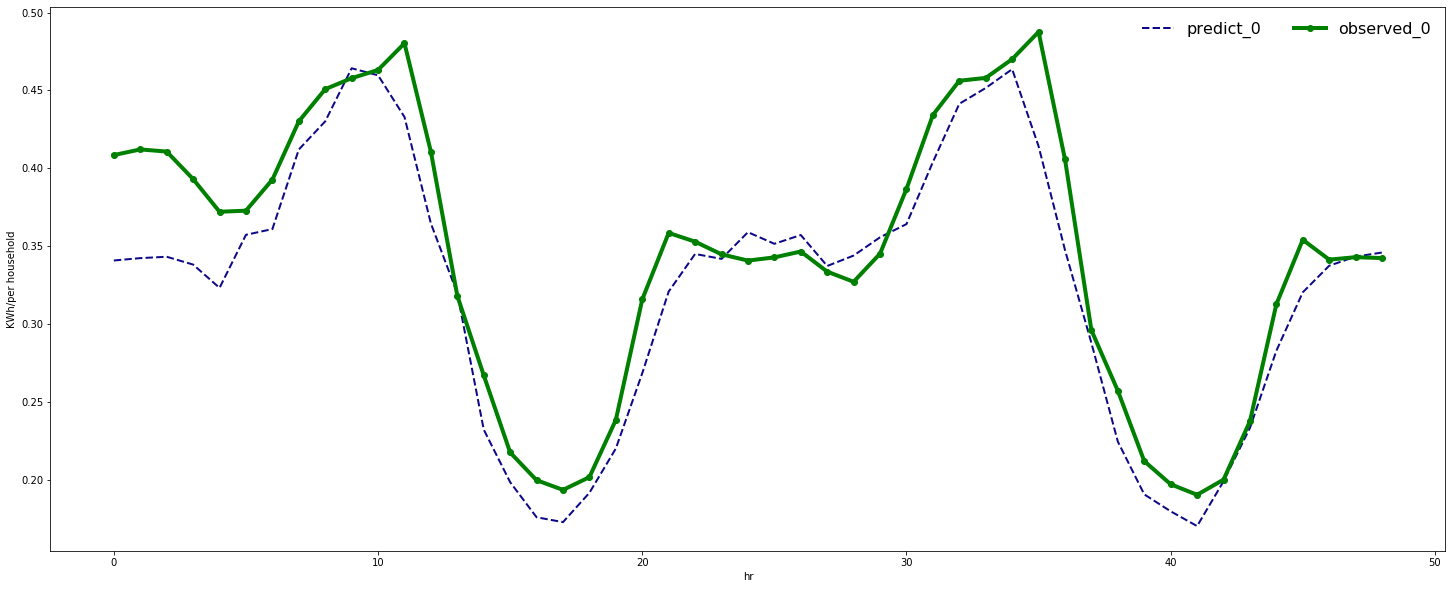

In [142]:
## assignment
real = test[:5,392:].as_data_frame().to_numpy()
guess = y_pred.to_numpy()
real = real[2:3,:49]
guess = guess[2:3,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "predict")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

## Specific models 

**H2ODeepLearningEstimator**

In [ ]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
data_dpl = H2ODeepLearningEstimator()
predictors = training.columns[0:392]
response = training.columns[392:393]
data_dpl.train(x = predictors,
               y= "response1(t+0)",
               training_frame = training,
               validation_frame = validation)

In [104]:
print(data_dpl.model_performance)

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1584459025587_2


Status of Neuron Layers: predicting response1(t+0), regression, gaussian distribution, Quadratic loss, 119,001 weights/biases, 1.5 MB, 112,300 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,392,Input,0,,,,,,,,,
1,,2,200,Rectifier,0,0,0,0.0467503,0.0193577,0,0.000225489,0.0890363,0.382551,0.0796806
2,,3,200,Rectifier,0,0,0,0.0276357,0.0353721,0,-0.0198098,0.0736831,0.973002,0.0167214
3,,4,1,Linear,,0,0,0.000541373,0.000198788,0,-0.00215572,0.053675,0.112552,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.004094984109203781
RMSE: 0.06399206286098129
MAE: 0.04711702638522245
RMSLE: 0.043658122956636874
Mean Residual Deviance: 0.004094984109203781

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.004333974047962542
RMSE: 0.06583292525752249
MAE: 0.048369559201350325
RMSLE: 0.045127742638271635
Mean Residual Deviance: 0.004333974047962542

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2020-03-17 20:11:09,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-03-17 20:11:11,3.461 sec,5615 obs/sec,1.0,1,11230.0,0.107774,0.011615,0.085006,0.501368,0.110648,0.012243,0.087994,0.490832
2,,2020-03-17 20:11:17,9.054 sec,7627 obs/sec,5.0,5,56150.0,0.082543,0.006813,0.062486,0.707506,0.084284,0.007104,0.064013,0.704566
3,,2020-03-17 20:11:23,14.294 sec,7259 obs/sec,8.0,8,89840.0,0.068906,0.004748,0.051174,0.796168,0.072182,0.005210,0.053347,0.783316
4,,2020-03-17 20:11:25,16.835 sec,7642 obs/sec,10.0,10,112300.0,0.063992,0.004095,0.047117,0.824205,0.065833,0.004334,0.048370,0.819757



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,w8(t+1),1.000000,1.000000,0.004059
1,w8(t+0),0.936156,0.936156,0.003800
2,w8(t+2),0.870737,0.870737,0.003534
3,w6(t+0),0.866126,0.866126,0.003515
4,w6(t+1),0.817794,0.817794,0.003319
5,w8(t+48),0.814338,0.814338,0.003305
6,w8(t+12),0.810031,0.810031,0.003288
7,w8(t+16),0.807253,0.807253,0.003276
8,w1(t+0),0.805817,0.805817,0.003271
9,w3(t+0),0.802281,0.802281,0.003256



See the whole table with table.as_data_frame()
<bound method ModelBase.model_performance of >
